# Hourly accumulations

This notebook takes the scans within the hour, converts them to rain rate then to rainfall amount, then adds it up until the end of the hour. The hour totals are saved in a hdf file.

Import libraries.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pylab inline

import pyart
import wradlib as wrl
import pandas as pd
import tempfile
import os
import numpy as np

import pickle

import pytz
import datetime as dt

from copy import deepcopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

import boto3
from botocore.handlers import disable_signing

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping


Read the shapefiles.

In [3]:
reader = shpreader.Reader(r'C:\Users\iac6311\Documents\Work\Data\GIS\USA\tl_2016_17_cousub\tl_2016_17_cousub.shp')
counties = list(reader.geometries())
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

Read the gauge locations file and gauge observations file into pandas dataframes, and get the location coordinates.

In [4]:
# load CCN gauge locations
CCN_gauge_locations_fname = 'C:/Users/iac6311/Documents/Work/Data/Cook_County/CookCounty_gage_locations.csv'
# load CCN gauge observations
CCN_gauge_observations_fname = 'C:/Users/iac6311/Documents/Work/Data/Cook_County/WaterYear2013.csv'

df_gauge_loc = pd.read_csv(CCN_gauge_locations_fname,header=0)
df_gauge = pd.read_csv(CCN_gauge_observations_fname,header=0)

x = df_gauge_loc['Longitude - West'].values
y = df_gauge_loc['Latitude'].values

In [5]:
def rounder(t):
    """
    Rounds the time to the nearest hour.
    """
    if t.minute >= 30:
        return t.replace(second=0, microsecond=0, minute=0, hour=t.hour+1)
    else:
        return t.replace(second=0, microsecond=0, minute=0)

In [6]:
path_rrfiles = r'C:\Users\iac6311\Documents\Work\SAVEUR\Processed_RainRetrievals\2013\04\18'

In [7]:
rrfiles = os.listdir(path_rrfiles)

In [8]:
rrfile = rrfiles[0]

radar = pyart.io.read_cfradial(os.path.join(path_rrfiles,rrfile))

In [9]:
gatefilter = pyart.filters.GateFilter(radar)
# Develop your gatefilter first
# exclude masked gates from the gridding
#gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_transition()
gatefilter.exclude_masked('reflectivity')

In [10]:
radar.fields.keys()

dict_keys(['differential_reflectivity', 'spectrum_width', 'velocity', 'differential_phase', 'reflectivity', 'cross_correlation_ratio', 'corrected_reflectivity', 'normalized_coherent_power', 'unfolded_differential_phase', 'corrected_differential_phase', 'specific_differential_phase', 'attenuation', 'rainrate_from_kdp', 'rainrate_from_attenuation', 'rainrate'])

In [11]:
# perform Cartesian mapping, limit to the reflectivity field.
grid = pyart.map.grid_from_radars(
    [radar], gatefilters=[gatefilter],
    grid_shape=(1, 600, 600),
    grid_limits=((2000, 2000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
    fields=['rainrate','rainrate_from_attenuation','rainrate_from_kdp'])

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


In [12]:
x_rad, y_rad = grid.get_point_longitude_latitude()

In [13]:
# 3.2 Get radar data
# Get slice
radar_slice0 = radar.get_slice(0)
rr_0 = radar.fields['rainrate']['data'][radar_slice0, :]

In [14]:
sitecoords = (radar.longitude['data'][0],radar.latitude['data'][0],radar.altitude['data'][0])
az = radar.azimuth['data'][radar_slice0]
r = radar.range['data']
proj = wrl.georef.epsg_to_osr(4326)

In [15]:
# save the radar parameters
with open('radarparams600x600.pkl','wb') as f:
    pickle.dump([sitecoords, az, r],f)

In [16]:
radar_depth = wrl.trafo.r_to_depth(rr_0,interval=256)

In [17]:
# create an empty dictionary
fname_dict = {}
for i in arange(1,25,1):
    fname_dict[i] = []
# fill in dictionary
for i in arange(len(rrfiles)):
    fname = rrfiles[i]
    dtime_utc = dt.datetime.strptime(fname,'radar_KLOT_%Y%m%d_%H%M%S.nc')
    fname_dict[dtime_utc.hour+1].append(dt.datetime.strftime(dtime_utc,'%Y/%m/%d/')+rrfiles[i])

In [18]:
fname_dict

{1: ['2013/04/18/radar_KLOT_20130418_000354.nc',
  '2013/04/18/radar_KLOT_20130418_000810.nc',
  '2013/04/18/radar_KLOT_20130418_001228.nc',
  '2013/04/18/radar_KLOT_20130418_001645.nc',
  '2013/04/18/radar_KLOT_20130418_002102.nc',
  '2013/04/18/radar_KLOT_20130418_002518.nc',
  '2013/04/18/radar_KLOT_20130418_002934.nc',
  '2013/04/18/radar_KLOT_20130418_003350.nc',
  '2013/04/18/radar_KLOT_20130418_003807.nc',
  '2013/04/18/radar_KLOT_20130418_004223.nc',
  '2013/04/18/radar_KLOT_20130418_004639.nc',
  '2013/04/18/radar_KLOT_20130418_005057.nc',
  '2013/04/18/radar_KLOT_20130418_005514.nc',
  '2013/04/18/radar_KLOT_20130418_005932.nc'],
 2: ['2013/04/18/radar_KLOT_20130418_010349.nc',
  '2013/04/18/radar_KLOT_20130418_010806.nc',
  '2013/04/18/radar_KLOT_20130418_011223.nc',
  '2013/04/18/radar_KLOT_20130418_011640.nc',
  '2013/04/18/radar_KLOT_20130418_012057.nc',
  '2013/04/18/radar_KLOT_20130418_012513.nc',
  '2013/04/18/radar_KLOT_20130418_013141.nc',
  '2013/04/18/radar_KLOT_20

In [19]:
for hour in list(fname_dict)[13:]:
    print(hour)
    fnames_within_hour = fname_dict[hour]
    hour_accum_rrZ = np.zeros((600,600))
    hour_accum_rrA = np.zeros((600,600))
    hour_accum_rrKDP = np.zeros((600,600))
    for fname in fnames_within_hour:
        print('.',end='')

        # get local time of radar
        fname = fname.rsplit('/',1)[-1]
        dtime_utc = dt.datetime.strptime(fname,'radar_KLOT_%Y%m%d_%H%M%S.nc')
        dtime_utc = pytz.utc.localize(dtime_utc)
        
        # read radar data
        radar = pyart.io.read_cfradial(os.path.join(path_rrfiles,fname))

        # grid 
        gatefilter = pyart.filters.GateFilter(radar)
        gatefilter.exclude_transition()
        gatefilter.exclude_masked('reflectivity')

        # perform Cartesian mapping, limit to the reflectivity field.
        grid = pyart.map.grid_from_radars(
            [radar], gatefilters=[gatefilter],
            grid_shape=(1, 600, 600),
            grid_limits=((2000, 2000), (-123000.0, 123000.0), (-123000.0, 123000.0)),
            fields=['rainrate','rainrate_from_kdp'])

        # 3.2 Get radar data
        # Get slice
        rrZ_0 = grid.fields['rainrate']['data']
        #rrA_0 = grid.fields['rainrate_from_attenuation']['data']
        rrKDP_0 = grid.fields['rainrate_from_kdp']['data']
        
        # convert rain rate to rain amount
        rrZ_amount = wrl.trafo.r_to_depth(rrZ_0,interval=345)
        #rrA_amount = wrl.trafo.r_to_depth(rrA_0,interval=345)
        rrKDP_amount = wrl.trafo.r_to_depth(rrKDP_0,interval=345)
        
        hour_accum_rrZ += rrZ_amount[0]
        #hour_accum_rrA += rrA_amount[0]
        hour_accum_rrKDP += rrKDP_amount[0]

    savefname = dt.datetime.strftime(dtime_utc.replace(microsecond=0,second=0,minute=0)+dt.timedelta(hours=1), '%Y%m%d_%H%M%S')
    wrl.io.to_hdf5('gridded_600x600_KLOT'+savefname+'_rrZ.hdf5', hour_accum_rrZ)
    #wrl.io.to_hdf5('gridded_600x600_KLOT'+savefname+'_rrA.hdf5', hour_accum_rrA)
    wrl.io.to_hdf5('gridded_600x600_KLOT'+savefname+'_rrKDP.hdf5', hour_accum_rrKDP)

    print('')

14
.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



15
.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



16
.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



17
.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



18
.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



19
.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



20
.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



21
.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



22
.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



23
.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)



24
.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


.

C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveur\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


In [20]:
x_rad, y_rad = grid.get_point_longitude_latitude()

# Saving the objects:
with open('radar_grid_600x600.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([x_rad, y_rad], f)

In [21]:
rrZ_amount

masked_array(
  data=[[[--, --, --, ..., 0.10642901062965393, 0.11045961827039719,
          0.11084410548210144],
         [--, --, --, ..., 0.11717130243778229, 0.11656365543603897,
          0.11925037950277328],
         [--, --, --, ..., 0.12348630279302597, 0.12478181719779968,
          0.12380573153495789],
         ...,
         [--, --, --, ..., 0.014383386820554733, 0.01455506682395935,
          0.014554532244801521],
         [--, --, --, ..., 0.014337399043142796, 0.014486943371593952,
          0.01459246501326561],
         [--, --, --, ..., 0.014084775932133198, 0.014378895983099937,
          0.014409555122256279]]],
  mask=[[[ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         ...,
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, False],
         [ True,  True,  True, ..., False, False, Fal

In [22]:
hour_accum_rrKDP.shape

(600, 600)

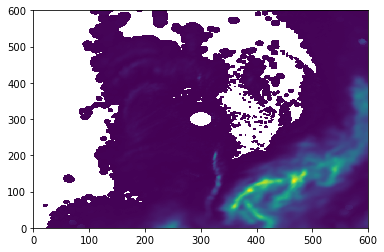

In [23]:
plt.pcolormesh(rrZ_amount[0])

In [24]:
rrZ_0.shape

(1, 600, 600)